This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [46]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity, plot_1to1_scatter, plot_1to1_uncertainty

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the data

In [25]:
# File and folder paths
dir_case = Path("./")
f_para = dir_case / "./data/Output_para.csv"
f_state = dir_case / "./data/Input_logq.csv"


In [26]:
df_para, df_state = pd.read_csv(f_para, index_col=0),pd.read_csv(f_state, index_col=0)
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values
x.shape, y.shape

((396, 1461), (396, 8))

In [27]:
# Parameters to be estimated
y_vars = ['PT-snow', 'PT-trans', 'SM-rate', 'SM-diff', 'PERM-s3', 'PERM-s4', 'PERM-g1', 'PERM-g4']

# Load the preliminary analysis results

In [28]:
f_data_save = dir_case / "results/data"
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

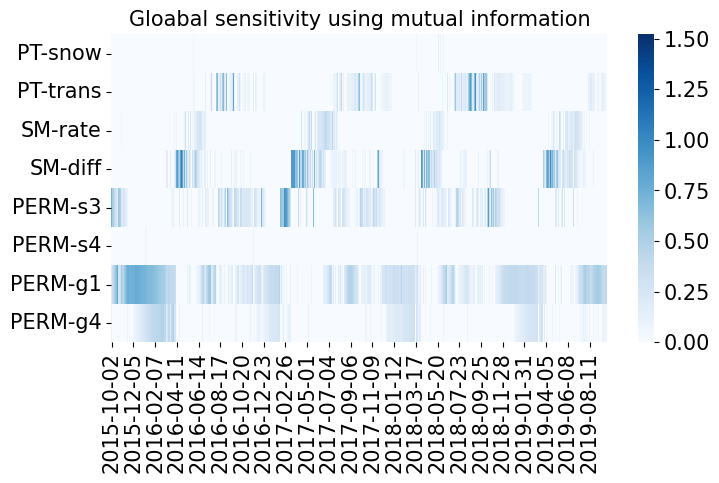

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity(data.sensitivity.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Gloabal sensitivity using mutual information');


(array([  24,  512,  287,  547,  618,   13, 1123,  513]), np.int64(3637))

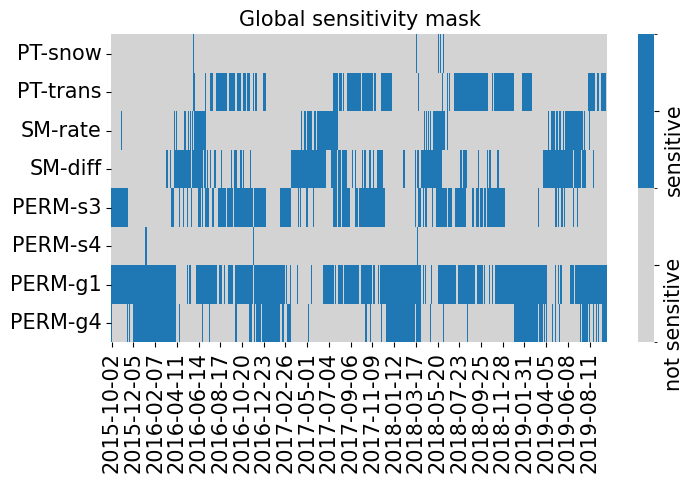

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity_mask(data.sensitivity_mask.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Global sensitivity mask')
data.sensitivity_mask.sum(axis=0), data.sensitivity_mask.sum()


(array([  3, 184,  89, 264, 353,   1, 547,  53]), np.int64(1494))

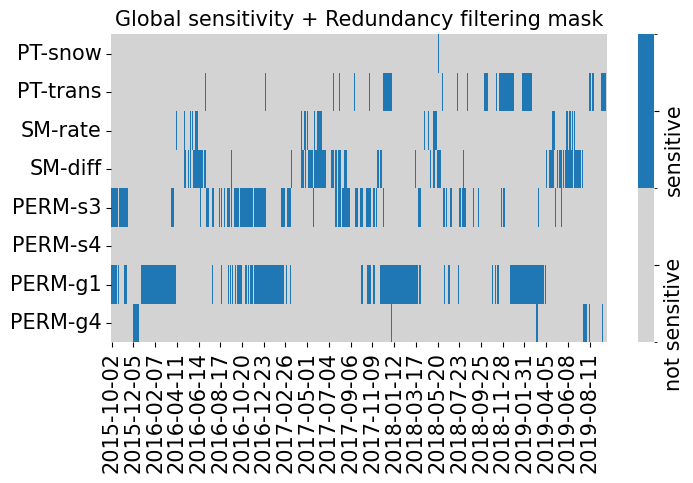

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_sensitivity_mask(data.cond_sensitivity_mask.T, ylabels=x_vars, xlabels=y_vars)
ax.set(title='Global sensitivity + Redundancy filtering mask')
data.cond_sensitivity_mask.sum(axis=0), data.cond_sensitivity_mask.sum()


# Load the mapping results
- `kim1`: The naive inverse mapping from all $\mathbf{Y}$ to all $\mathbf{X}$, labeled as $M_0$
- `kim2`: The knowledge-informed inverse mapping from sensitive $\mathbf{Y}$ to each of $\mathbf{X}$ using global sensitivity analysis, labeled as $M_1$
- `kim3`: The knowledge-informed inverse mapping from sensitive $\mathbf{Y}$ to each of $\mathbf{X}$ using global sensitivity analysis + redundancy filtering check, labeled as $M_2$

In [32]:
f_kim_save1 = dir_case / "results/map_many2many"
f_kim_save2 = dir_case / "results/map_many2one"
f_kim_save3 = dir_case / "results/map_many2one_cond"


In [33]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs={}, map_option='many2many')
kim2 = KIM(data, map_configs={}, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')

# Load the trained mappings
kim1.load(f_kim_save1)
kim2.load(f_kim_save2)
kim3.load(f_kim_save3)


In [23]:
# print(np.mean([loss[-1] for loss in kim1.maps[0].loss_val_ens]))
# print(np.mean([loss[-1] for loss in kim2.maps[0].loss_val_ens]))
# print(np.mean([loss[-1] for loss in kim3.maps[0].loss_val_ens]))
# # kims = [kim1, kim2, kim3]


In [51]:
# Calculate the performance metrics
kims = [kim1, kim2, kim3]
labels = ['$M_0$', '$M_1$', '$M_2$']
results = {}
for i,kim in enumerate(kims):
    label = labels[i]
    results[label] = kim.evaluate_maps_on_givendata()


# Plot the training results

## Prediction versus true

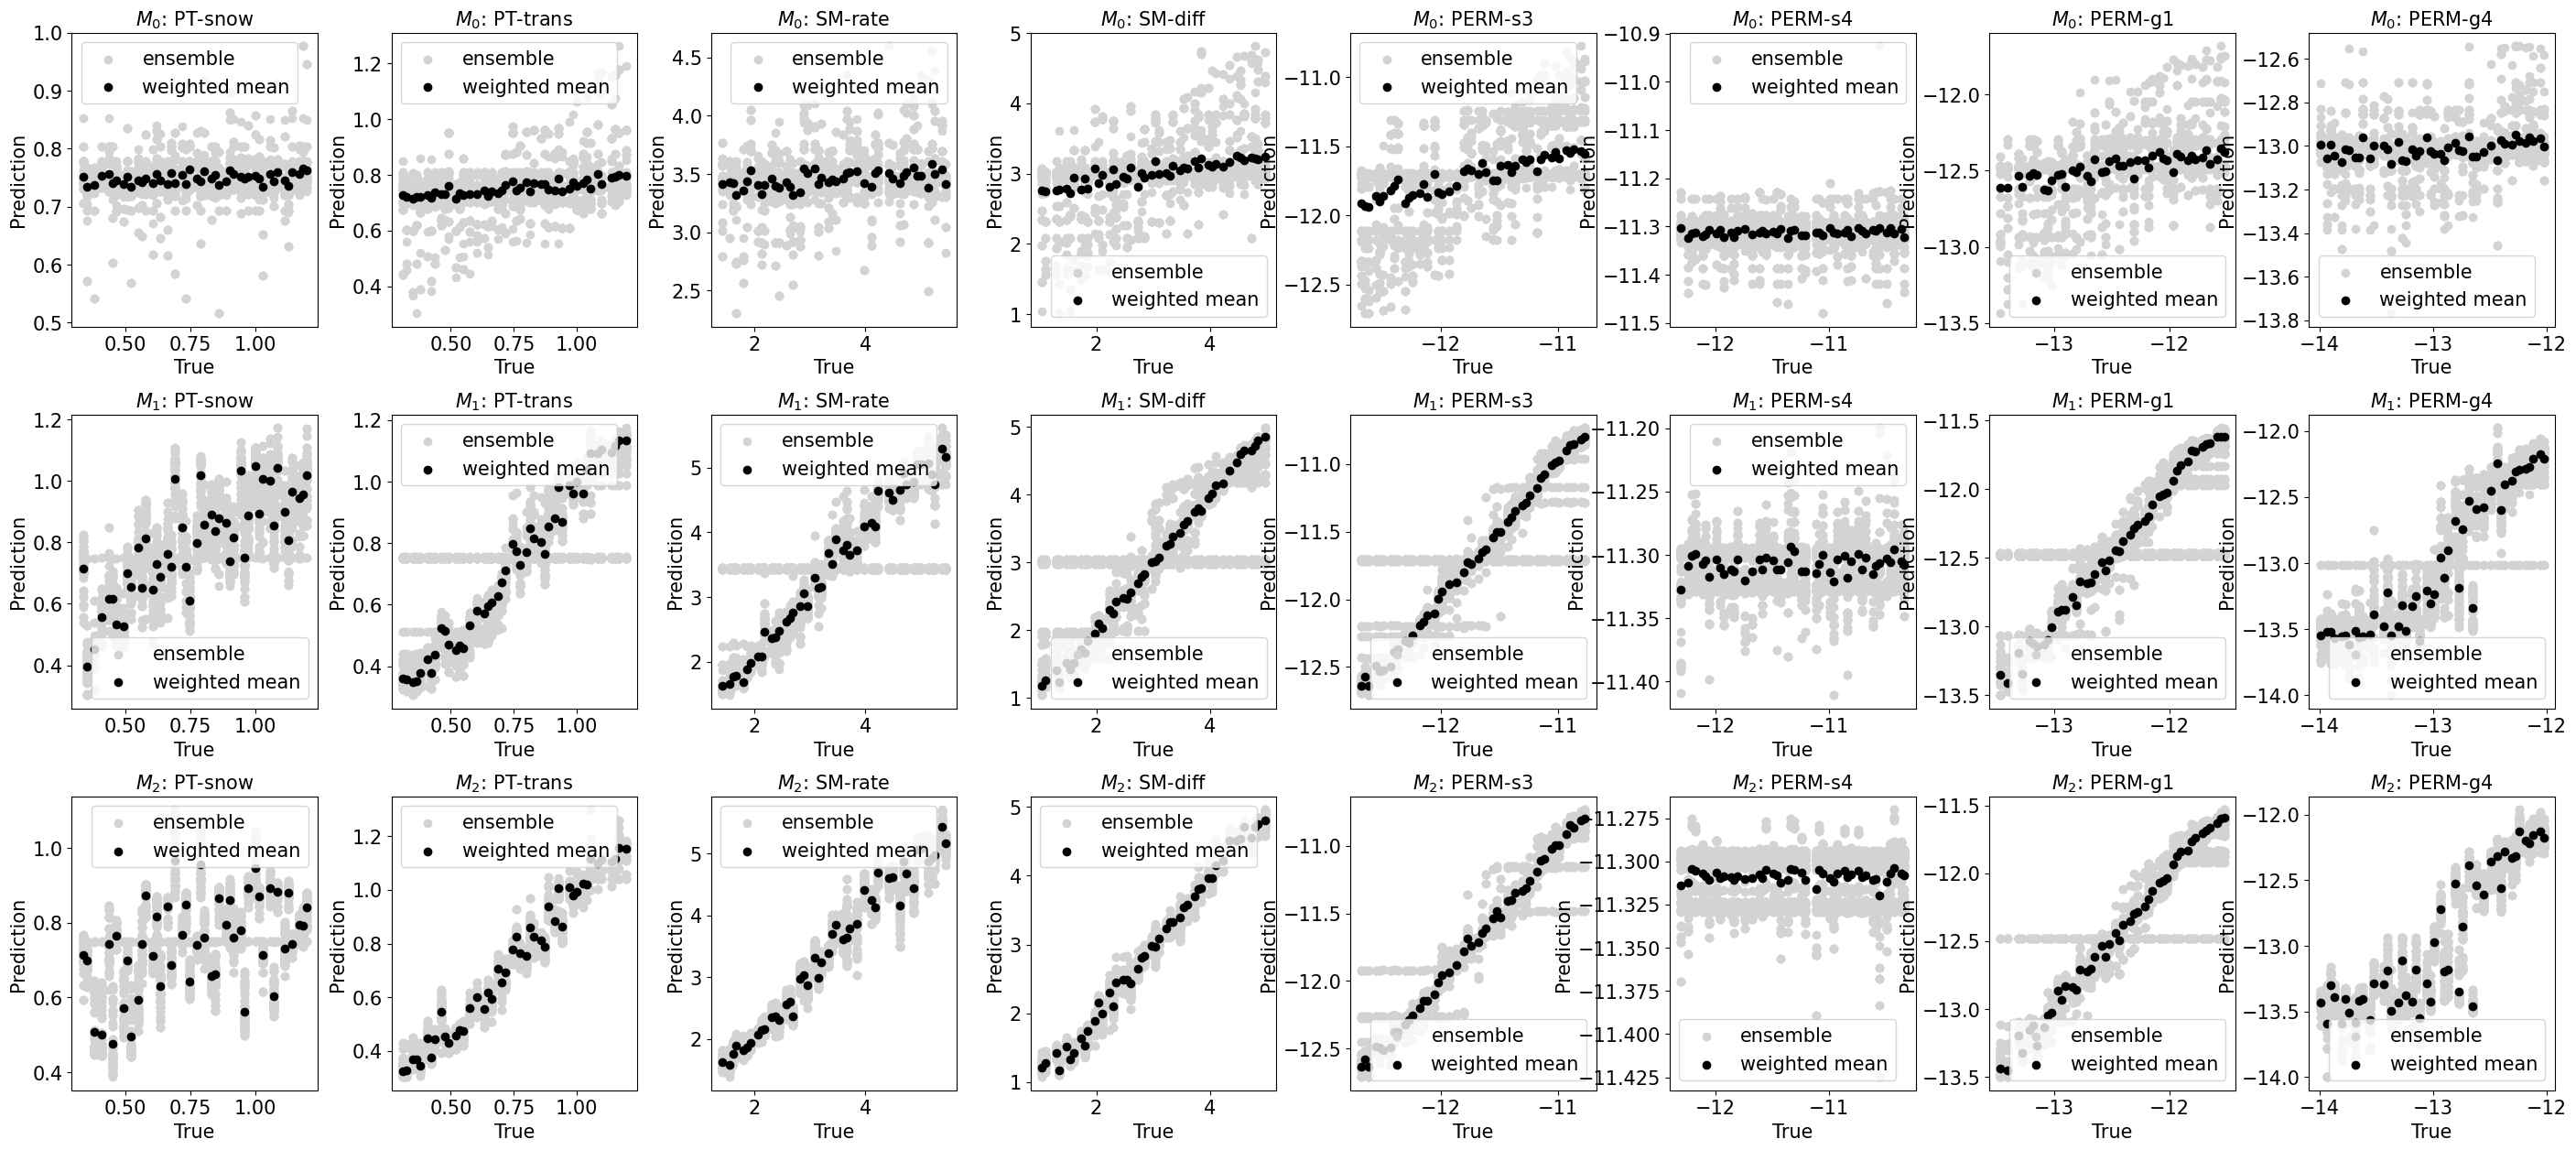

In [42]:
train_or_test = 'test'
fig, axes = plt.subplots(3, len(y_vars), figsize=(35,15))
for i in range(len(y_vars)):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[j, i]
        plot_1to1_scatter(r, ax=ax, iy=i, train_or_test='test', model=model, y_var=y_var)
plt.subplots_adjust(hspace=0.3, wspace=0.3)


## Performance versus true (with uncertainty)

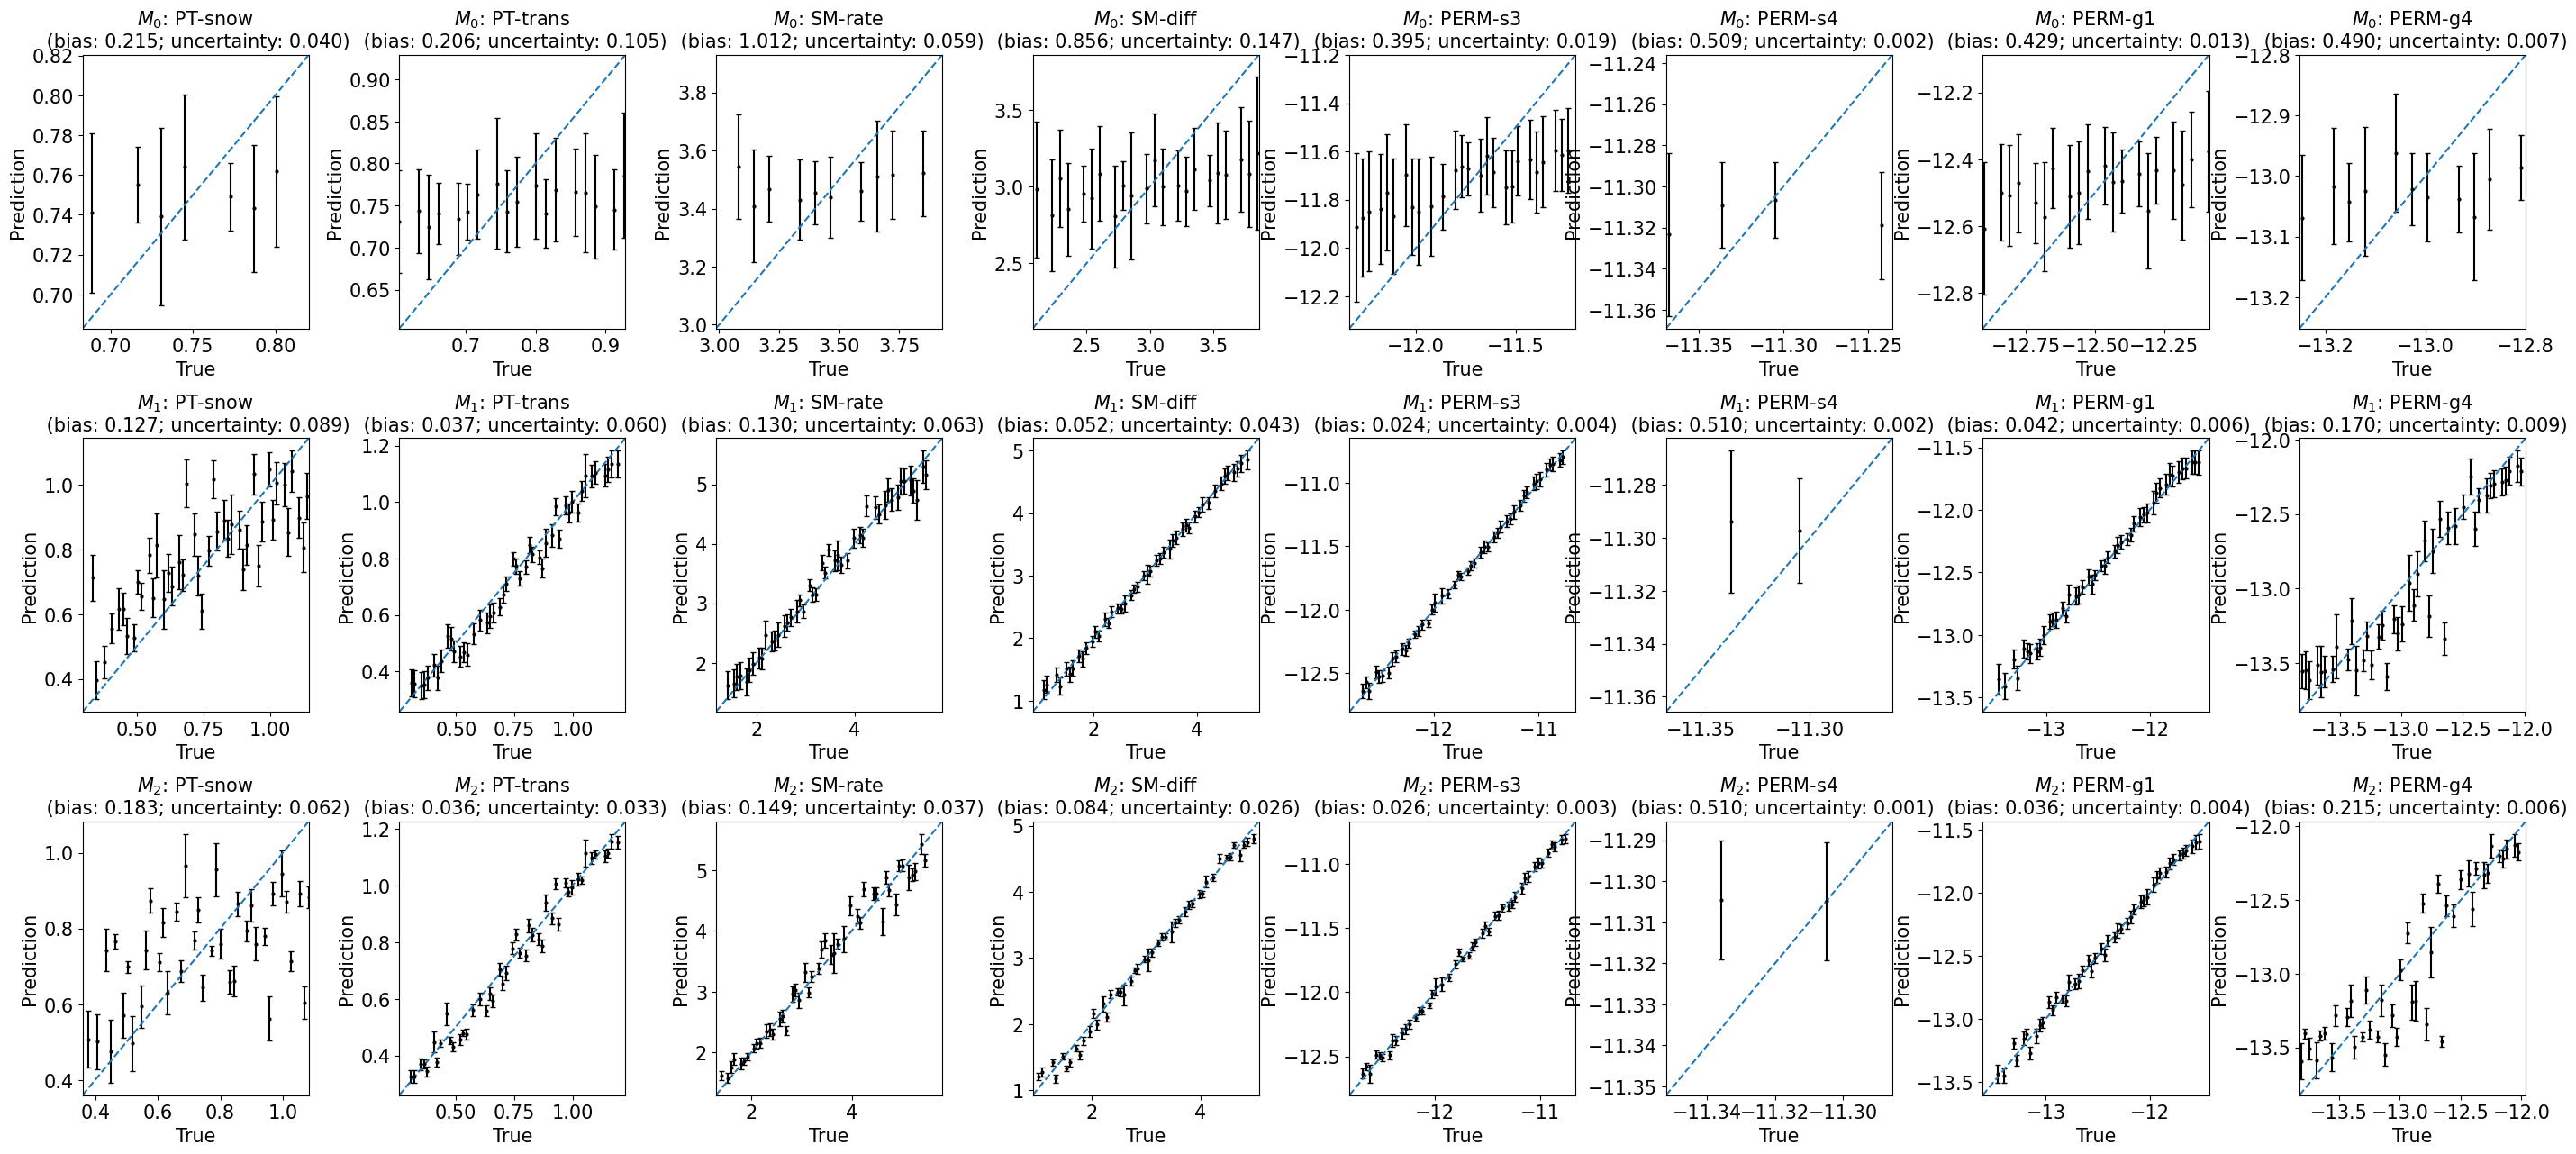

In [50]:
train_or_test = 'test'
fig, axes = plt.subplots(3, len(y_vars), figsize=(35, 15))
for i in range(len(y_vars)):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[j, i]
        plot_1to1_uncertainty(r, iy=i, ax=ax, train_or_test=train_or_test, model=model, y_var=y_var)
plt.subplots_adjust(hspace=0.4, wspace=0.4)


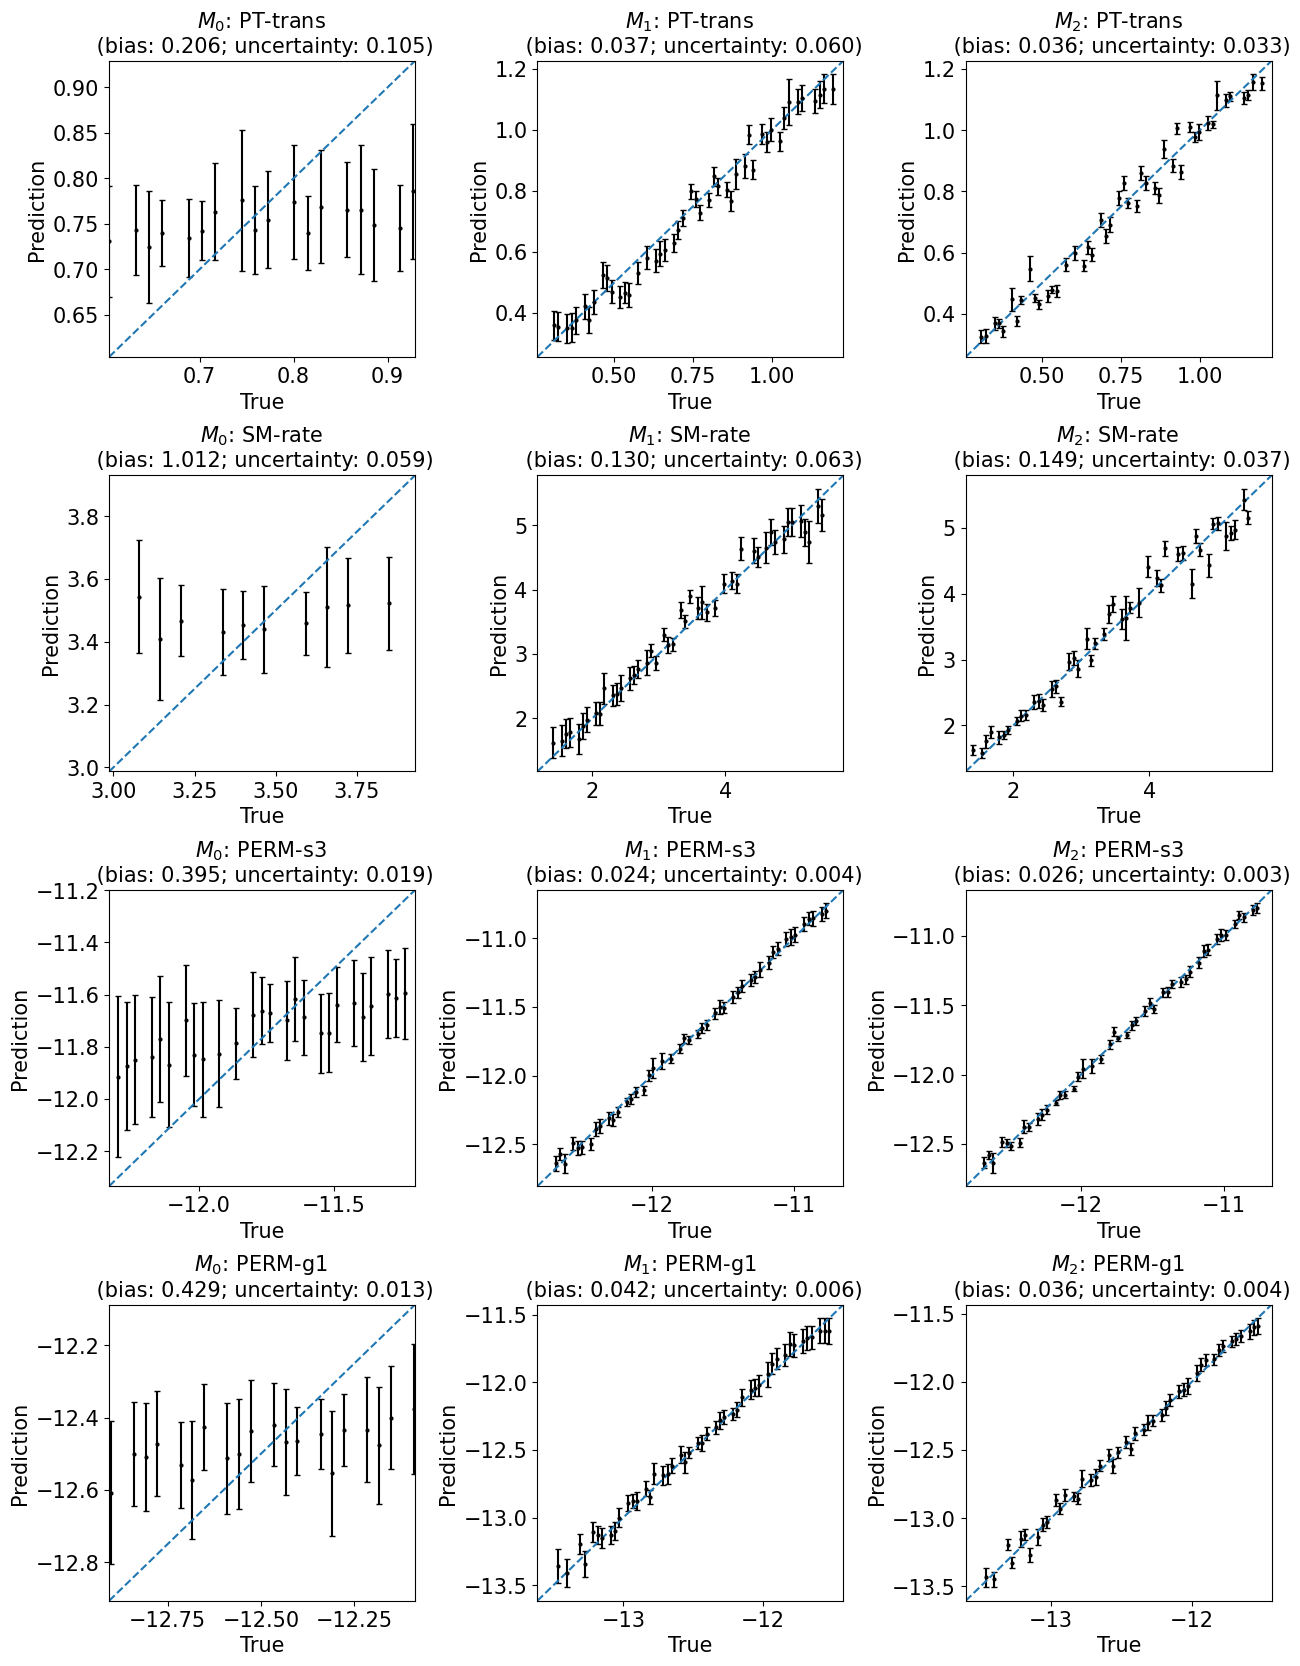

In [49]:
train_or_test = 'test'
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
for ind,i in enumerate([1, 2, 4, 6]):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[ind,j]
        plot_1to1_uncertainty(r, iy=i, ax=ax, train_or_test=train_or_test, model=model, y_var=y_var)
plt.subplots_adjust(hspace=0.4, wspace=0.4)


# Backup plots

In [ ]:
# train_or_test = 'test'
# y_vars_plot = ['PERM-s3', 'PERM-g1', 'SM-diff', 'PT-trans']
# models_plot = ['Original inverse mapping', 'KIM']
# fig, axes = plt.subplots(len(models_plot),len(y_vars_plot),figsize=(15,10))
# for i,y_var in enumerate(y_vars_plot):
#     for j,model in enumerate(models_plot):
#         r = results[model]
#         ax = axes[j,i]
#         ivar = y_vars.index(y_var)
#         for k in range(100):
#             ax.scatter(r['true'][train_or_test][...,ivar], r['ens predict'][train_or_test][k,...,ivar], 
#                        color='lightgrey', label='ensemble' if k ==0 else None)
#         ax.scatter(r['true'][train_or_test][...,ivar], r['weighted mean predict'][train_or_test][...,ivar], 
#                    color='black', label='weighted mean')
#         lim = ax.get_xlim()
#         ax.set(xlim=lim, ylim=lim, xlabel='True' if j==1 else '', ylabel='Prediction' if i==0 else '', title=f"{y_var}")
#         # ax.legend()
# plt.subplots_adjust(hspace=0.3, wspace=0.3)


In [ ]:
# train_or_test = 'test'
# fig, axes = plt.subplots(len(y_vars),3,figsize=(15,40))
# for i in range(len(y_vars)):
#     y_var = y_vars[i]
#     for j in range(3):
#         model = labels[j]
#         r = results[model]
#         ax = axes[i, j]
#         plot_1to1_scatter(r, ax=ax, iy=i, train_or_test='test', model=model, y_var=y_var)
#         # for k in range(100):
#         #     ax.scatter(r['true'][train_or_test][...,i], r['ens predict'][train_or_test][k,...,i], 
#         #                color='lightgrey', label='ensemble' if k ==0 else None)
#         # ax.scatter(r['true'][train_or_test][...,i], r['weighted mean predict'][train_or_test][...,i], 
#         #            color='black', label='weighted mean')
#         # lim = ax.get_xlim()
#         # ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
#         # ax.legend()


In [ ]:
# train_or_test = 'test'
# fig, axes = plt.subplots(len(y_vars),3,figsize=(15,40))
# for i in range(len(y_vars)):
#     y_var = y_vars[i]
#     for j in range(3):
#         model = labels[j]
#         r = results[model]
#         ax = axes[i,j]
#         x = r['true'][train_or_test][...,i]
#         y = r['weighted mean predict'][train_or_test][...,i]
#         yens = r['ens predict'][train_or_test][...,i]
#         w = r['weights'][...,i]
#         std = np.sqrt(np.average((yens-y)**2, weights=w, axis=0))
#         ax.errorbar(x, y, std, color='black', ecolor='grey',  linestyle='None', fmt='o', markersize=2, capsize=2)
#         lim = ax.get_xlim()
#         ax.plot(lim, lim, '--', color='tab:blue')
#         ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
